In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from classes import Bandpasses, Sed, LightCurve, SNSurvey

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the LSST filters

In [3]:
bandpasses = Bandpasses()

Simulate a survey of SN1a

In [11]:
%%time
model = sncosmo.Model(source='salt2-extended')
params = {'z': 0, 't0': 0, 'x0': 1e-5, 'x1': 0.1, 'c': -0.1}
model.update(params)

survey = SNSurvey(model=model, zmax=0.75, area=4, cadence=1)
survey.simulate(bandpasses, norm=10, Ncpus=8)

print(survey)

SN Survey Simulation: 

    N obs = 1391   
     zmin = 0      
     zmax = 0.75   
     area = 4      
 duration = 1000.0 
  cadence = 1      
flux errf = 0.05   

Model: 
source:
  class      : SALT2Source
  name       : 'salt2-extended'
  version    : 2.0
  phases     : [-20, .., 50] days
  wavelengths: [1700, .., 24990] Angstroms
parameters:
  z  = 0.0
  t0 = 0.0
  x0 = 1e-05
  x1 = 0.1
  c  = -0.1
CPU times: user 1.73 s, sys: 420 ms, total: 2.15 s
Wall time: 15.5 s


In [12]:
time = np.arange(model.mintime(), model.maxtime() + 1)
wavelen = np.arange(model.minwave(), 11100, 1)
lc = LightCurve(time, wavelen)
lc.from_model(model)

Now we start with a totally null light curve

In [13]:
time = np.arange(model.mintime(), model.maxtime() + 1)
wavelen = np.arange(model.minwave(), 11100, 10)
lcn = LightCurve(time, wavelen)
lcn.null()

Let's make the time-slice training sets:

In [14]:
%time training_sets = lcn.training_sets(survey.obs)

CPU times: user 36.8 s, sys: 268 ms, total: 37.1 s
Wall time: 37.1 s


Pull out a specific time

In [15]:
T = 0
objects = training_sets[T]

Now the SED object

In [9]:
# area = 1/5
sed = Sed()
sed.wavelen = np.arange(1000, 11100, 100)
sed.null()

%time EDbins,pert,bins,infoDen,cumInfo = sed.train(objects, bandpasses, return_all=True)

N = 28
Nsplit = 1
max width = 1700.0
alpha = 0.3003102702702703
CPU times: user 48.3 s, sys: 725 ms, total: 49 s
Wall time: 12.3 s


In [10]:
# area = 1
sed = Sed()
sed.wavelen = np.arange(1000, 11100, 100)
sed.null()

%time EDbins,pert,bins,infoDen,cumInfo = sed.train(objects, bandpasses, return_all=True)

34
N = 34
Nsplit = 3
max width = 700.0
alpha = 0.2002101801801802
CPU times: user 1min 39s, sys: 1.47 s, total: 1min 41s
Wall time: 25.5 s


In [16]:
# area = 4
sed = Sed()
sed.wavelen = np.arange(1000, 11100, 100)
sed.null()

%time EDbins,pert,bins,infoDen,cumInfo = sed.train(objects, bandpasses, return_all=True)

N = 39
Nsplit = 1
max width = 1400.0
alpha = 0.5005104504504504
CPU times: user 5min 34s, sys: 6.11 s, total: 5min 40s
Wall time: 1min 29s


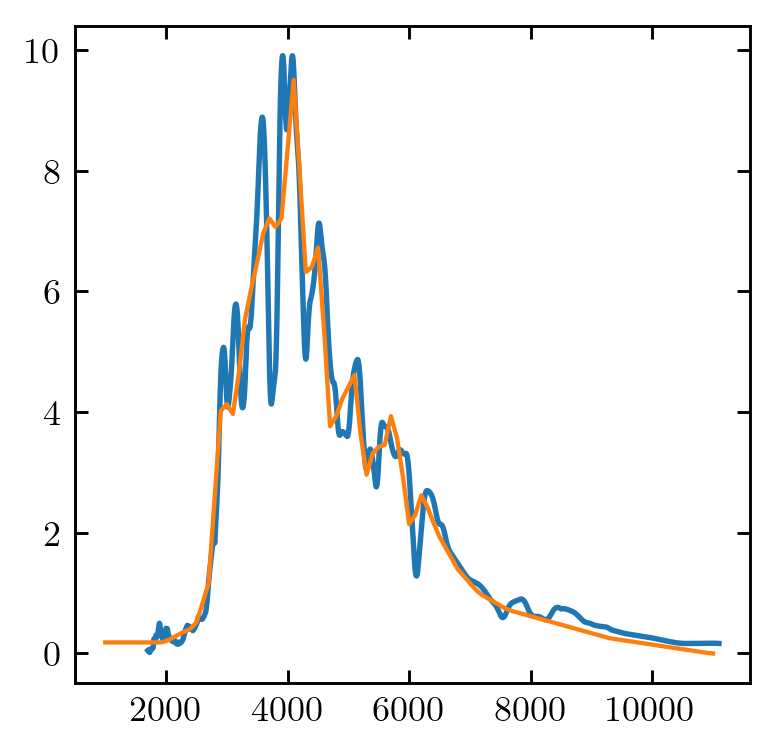

In [10]:
SED = lc.sed_slice(T)
plt.plot(SED.wavelen, SED.flambda, lw=1.5)
plt.plot(sed.wavelen, sed.flambda)

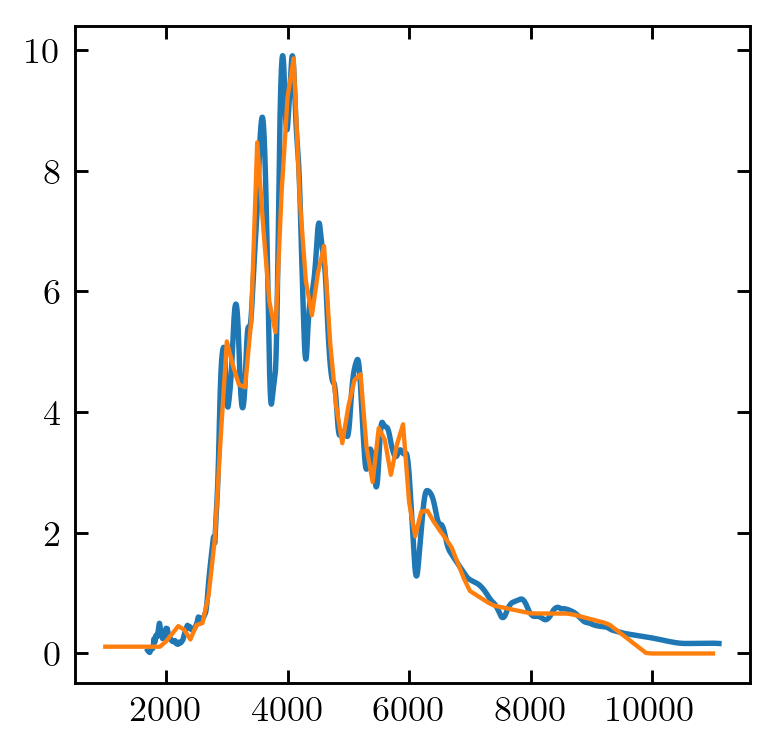

In [17]:
SED = lc.sed_slice(T)
plt.plot(SED.wavelen, SED.flambda, lw=1.5)
plt.plot(sed.wavelen, sed.flambda)

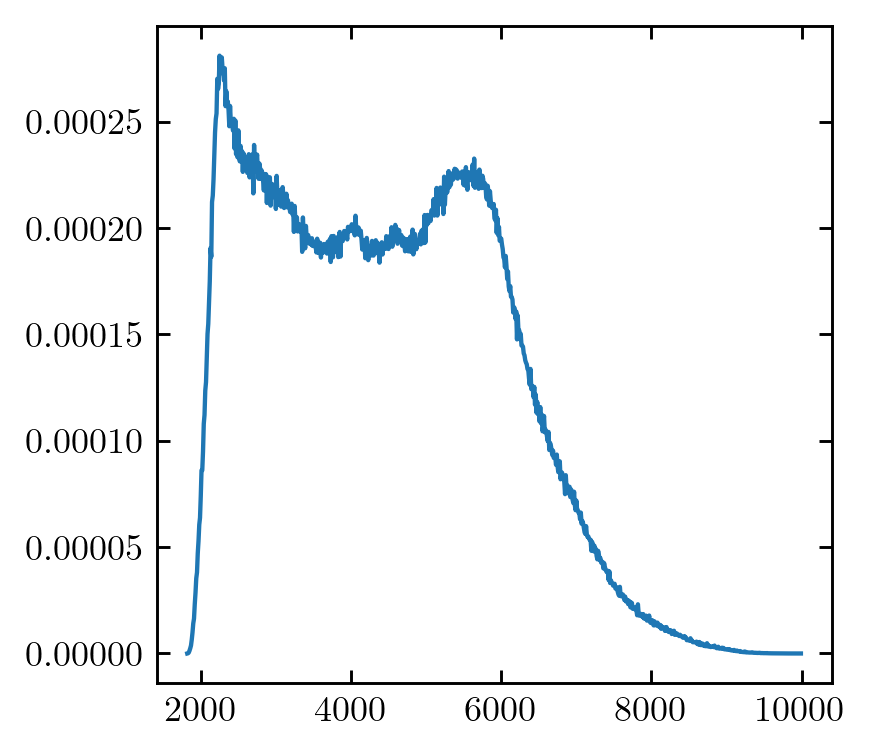

In [18]:
plt.plot(bins,infoDen)

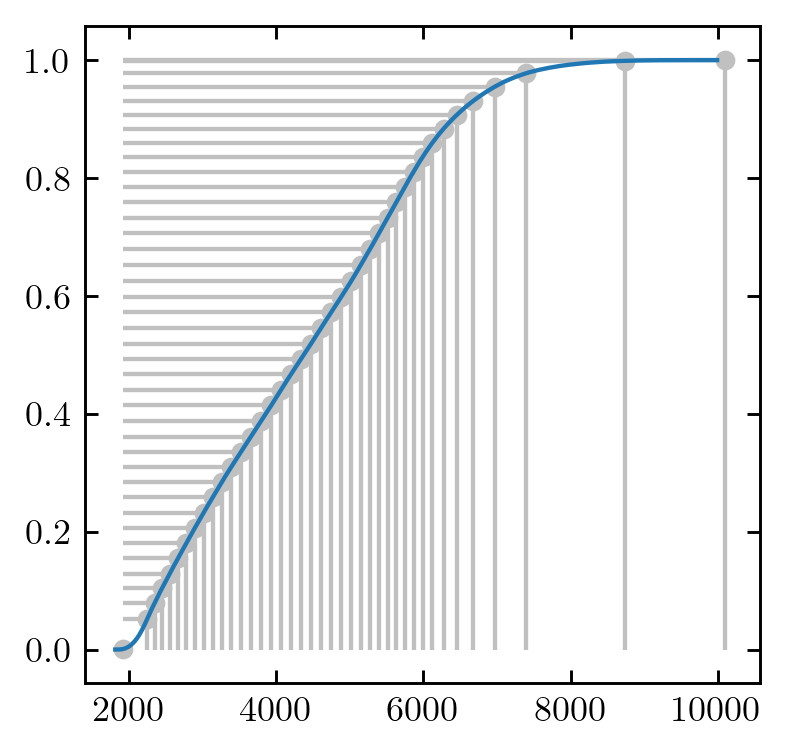

In [19]:
plt.plot(bins,cumInfo)

for w in EDbins:
    I = np.interp(w, bins, cumInfo)
    plt.vlines(w,0,I,color='silver')
    plt.hlines(I,EDbins[0],w,color='silver')
    plt.scatter(w,I,c='silver',s=20)